# Using a Different Solver

The steps taken in the [first notebook](TV_denoising_with_PDHG.ipynb) are largely the same for all solvers. However, the specific form

$$
    \min_{x \in X} \left[ f(x) + g(L x) \right]
$$

required us to rewrite the problem using product spaces.

Other optimization methods, such as the (primal-dual variants of the) [Forward-Backward](https://github.com/odlgroup/odl/blob/master/odl/solvers/nonsmooth/forward_backward.py) [BC2015] and [Douglas-Rachford](https://github.com/odlgroup/odl/blob/master/odl/solvers/nonsmooth/douglas_rachford.py) [BH2013] methods, provide alternatives to PDHG that can be easier to set up.

## The Douglas-Rachford Solver

We will take a closer look at the Douglas-Rachford splitting based method. Without going into the mathematical details of why and how, we observe that this method can solve problems of the form

$$
    \min_{x \in X} \left[ f(x) + \sum_{i=1}^n g_i (L_i x) \right]
$$

with convex functions $f$, $g_1, \dots, g_n$ and linear operators $L_1, \dots, L_n$. So in contrast to the PDHG method, we may have *any number of functions composed with linear operators*, which makes it much easier to set up the problem.

## Setting Up the Problem

We consider again the TV denoising problem

$$
    \min_{x \geq 0} \left[\| x - y \|_2^2 + \alpha \| \nabla x \|_1 \right],
$$

or, rewriting the positivity constraint,

$$
    \min_x \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 + \iota_0(x) \right].
$$

This form is already in the right shape for our solver, since we can choose the functions

$$
    f = \iota_0,\quad g_1 = \|\cdot - y\|_2^2, \quad g_2 = \|\cdot\|_1,
$$

and the linear operators

$$
    L_1 = I, \quad L_2 = \nabla.
$$

## Parameter Selection

In exchange for the easy problem setup, we somewhat trade the simplicity of finding good optimization parameters. The Douglas-Rachford method is guaranteed to converge if $\tau$ and $\sigma_1, \dots, \sigma_n$ are chosen such that

$$
    \tau \sum_{i=1}^n \sigma_i \|L_i\|^2 < 4.
$$

In our case, we have three parameters $\tau, \sigma_1, \sigma_2$, which makes it a bit more complicated to pick good values compared to PDHG with two parameters. As a rule of thumb, it often makes sense to have the $\sigma_i$ parameters balance the operator norms, i.e., to choose

$$
    \sigma_i = c \|L_i\|^{-2},
$$

and to select $\tau$ such that the sum converges, i.e.,

$$
    \tau < \frac{4}{nc}.
$$

It also makes sense to keep the sum in the order of 1 since otherwise, the step sizes are too small. Overall selecting good parameters is a bit of a trial-and-error procedure.

---

**Note:**

The helper function `odl.solvers.douglas_rachford_pd_stepsize` implements the above step size choice. Invoke

    ?? odl.solvers.douglas_rachford_pd_stepsize
    
to find out the details.

---

## Implementation

We consider the same scenario as in the [first notebook](TV_denoising_with_PDHG.ipynb). As before, we define a reconstruction space $X$ using uniform sampling on the rectangle $[0, N]$

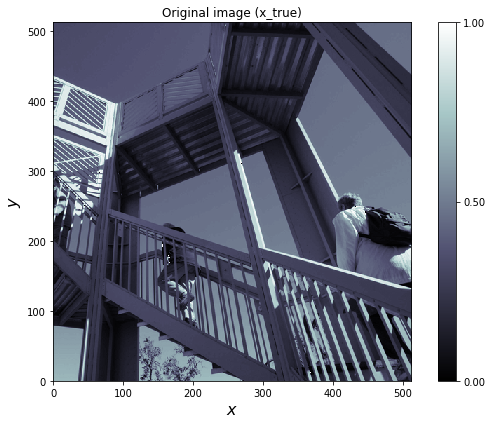

<Figure size 432x288 with 0 Axes>

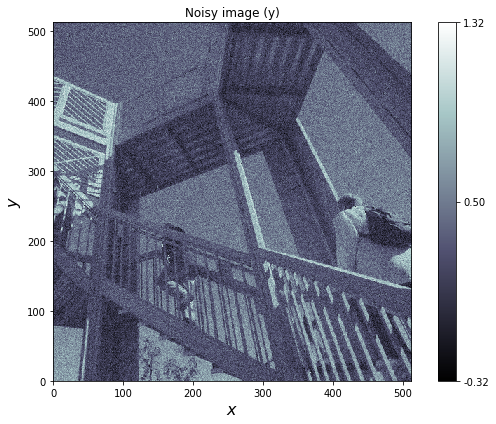

<Figure size 432x288 with 0 Axes>

In [2]:
%matplotlib inline
import numpy as np
import scipy.misc

import odl

# Generate test image
image = scipy.misc.ascent().astype('float32')

# Create reconstruction space
shape = image.T.shape
X = odl.uniform_discr(min_pt=[0, 0], max_pt=shape, shape=shape)

# Wrap image as space element, generate noisy variant and display
image /= image.max()
x_true = X.element(np.rot90(image, -1))
# To get predictable randomness, we explicitly seed the random number generator
with odl.util.NumpyRandomSeed(123):
    y = x_true + 0.1 * odl.phantom.white_noise(X)
    
x_true.show(title='Original image (x_true)', aspect=1, figsize=(8, 6))
y.show(title='Noisy image (y)', aspect=1, figsize=(8, 6))
pass

Now we set up the functions and the linear operators:

$$
    f = \iota_0,\quad g_1 = \|\cdot - y\|_2^2, \quad g_2 = \|\cdot\|_1, \\
    L_1 = I, \quad L_2 = \nabla.
$$

In [3]:
ident = odl.IdentityOperator(X)
grad = odl.Gradient(X)  # need this here for L1Norm below

# Function without linear operator
f = odl.solvers.IndicatorNonnegativity(X)

# Functions to be composed with linear operators. L[i] applies to g[i].
alpha = 0.15
g = [odl.solvers.L2NormSquared(X).translated(y),
     alpha * odl.solvers.L1Norm(grad.range)]
L = [ident, grad]

# We check if everything makes sense by evaluating the total functional at 0
x = X.zero()
print(f(x) + sum(g[i](L[i](x)) for i in range(len(g))))

43091.2686275999


Next we select the $\tau$ and $\sigma_i$ parameters for the optimization, using the `douglas_rachford_pd_stepsize` helper function:

In [4]:
grad_norm = 1.1 * odl.power_method_opnorm(grad, xstart=y, maxiter=20)
opnorms = [1, grad_norm]  # identity has norm 1
# The function can be called either with a list of operators or a list
# of operator norms. The latter option helps avoiding re-calculation of the
# norms.
tau, sigmas = odl.solvers.douglas_rachford_pd_stepsize(opnorms)
print('tau:', tau)
print('sigmas:', sigmas)

tau: 0.24816822937222938
sigmas: (4.029524659661783, 0.43904075251519453)


Now we're ready to run the solver!

In [6]:
# Starting point
x = X.zero()

# Run PDHG method. The vector `x` is updated in-place.
odl.solvers.douglas_rachford_pd(x, f, g, L, tau=tau, sigma=sigmas, niter=200)

We again visually inspect the results and evaluate some quality metrics from `odl.contrib.fom`:

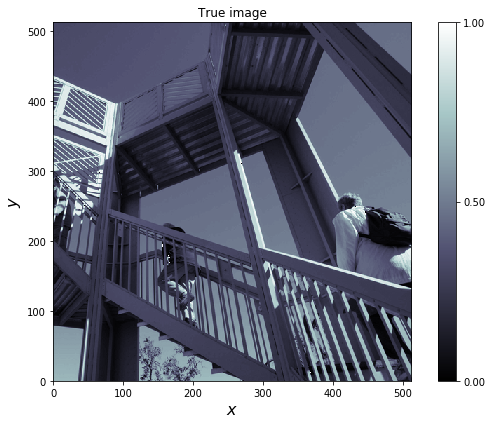

<Figure size 432x288 with 0 Axes>

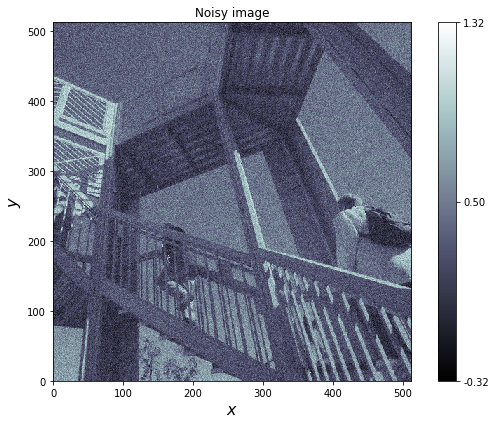

<Figure size 432x288 with 0 Axes>

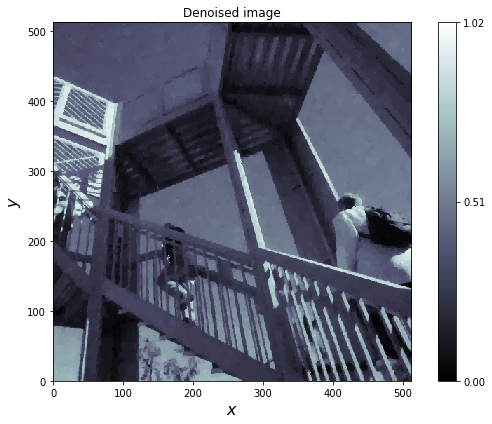

<Figure size 432x288 with 0 Axes>

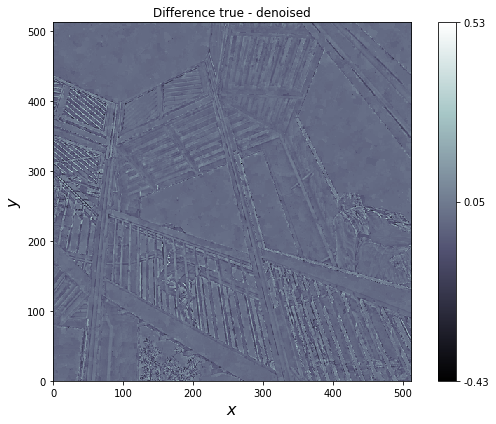

<Figure size 432x288 with 0 Axes>

In [8]:
x_true.show('True image', aspect=1, figsize=(8, 6))
y.show('Noisy image', aspect=1, figsize=(8, 6))
x.show('Denoised image', aspect=1, figsize=(8, 6))
(x_true - x).show('Difference true - denoised', aspect=1, figsize=(8, 6))
pass

In [9]:
from odl.contrib import fom

print('Noisy')
print('-----')
print('Mean squared error:', fom.mean_squared_error(y, x_true))
print('PSNR:', fom.psnr(y, x_true))
print('SSIM:', fom.ssim(y, x_true))
print('')

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x, x_true))
print('PSNR:', fom.psnr(x, x_true))
print('SSIM:', fom.ssim(x, x_true))

Noisy
-----
Mean squared error: 0.00996207815232703
PSNR: 20.0165005556
SSIM: 0.338040264996

Denoised
--------
Mean squared error: 0.0016107035575462587
PSNR: 27.9298438209
SSIM: 0.845683353973


## References

[BC2015] Bot, R I, and Csetnek, E R. *On the convergence rate of a forward-backward type primal-dual splitting algorithm for convex optimization problems*. Optimization, 64.1 (2015), pp 5--23.

[BH2013] Bot, R I, and Hendrich, C. *A Douglas-Rachford type primal-dual method for solving inclusions with mixtures of     composite and parallel-sum type monotone operators*. SIAM Journal on Optimization, 23.4 (2013), pp 2541--2565.